In [1]:
import numpy as np
import scipy.linalg as spl
import scipy.sparse as sps
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator
from joblib import Parallel, delayed
import h5py

In [2]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['font.size']=20
plt.rcParams["text.usetex"]=True

## Some quality control and plotting functions

### Count the number of zero entries

In [4]:
def count_non_zero_entries(A):
    """
    Function that counts the number of non-zero elements in an adjacency matrix
    
    Input:
    A: an adjacency matrix either containing 0's and 1's, or +1, -1, 0
    Output:
    n: number of non-zero elements
    """
    
    return np.count_nonzero(A)

In [5]:
A = np.array([[True, False],[False, True]])
B = np.array([[-1, 0, 1],[1, 0, 1], [0, 0, -1] ])
print(count_non_zero_entries(A))
print(count_non_zero_entries(B))

2
5


### Plot adjacency matrix

In [123]:
def plot_adjacency_matrix(A, axes):
    """
    Function that plots the adjacency matrix of an array containing either 
    (a) 0's and 1's or
    (b) 0's, 1's and -1's
    
    Input:
    1. A: adjacency matrix
    2. axes: matplotlib axes object
    
    Output:
    1. plot_obj: return the plotted object
    """
    
    if np.min(A) == 0.0:
        # matrix of 0's and 1's
        plot_obj = axes.imshow(A)
        plot_obj.set_cmap("Reds")
        divider = make_axes_locatable(axes)
        colorbar_axes = divider.append_axes("right", size="10%", pad=0.1)
        plt.colorbar(plot_obj, ticks=range(2), label='Connection', cax=colorbar_axes)
        axes.xaxis.set_major_locator(MaxNLocator(3))
        axes.yaxis.set_major_locator(MaxNLocator(3))
        return plot_obj
    elif np.min(A) == -1.0:
        # matrix of 0's and 1's and -1's
        plot_obj = axes.imshow(A)
        plot_obj.set_cmap("RdBu_r")
        divider = make_axes_locatable(axes)
        colorbar_axes = divider.append_axes("right", size="10%", pad=0.1)
        plt.colorbar(plot_obj, ticks=np.arange(3)-1, label='Connection', cax=colorbar_axes)
        axes.xaxis.set_major_locator(MaxNLocator(3))
        axes.yaxis.set_major_locator(MaxNLocator(3))
        return plot_obj

### Plot community matrix

In [154]:
def plot_community_matrix(W, axes):
    """
    Function that plots the community matrix of an array containing either 
    (a) all positive elements
    (b) a mixture of positive and negative elements
    
    Input:
    1. W: community matrix 
    2. axes: matplotlib axes object
    
    Output:
    1. plot_obj: return the plotted object
    """
    if np.min(W) == 0.0:
        # matrix of positive numbers
        plot_obj = axes.imshow(W-np.diag(np.diag(W)))
        plot_obj.set_cmap("Reds")
        divider = make_axes_locatable(axes)
        colorbar_axes = divider.append_axes("right", size="10%", pad=0.1)
        plt.colorbar(plot_obj, label='Interaction strength', cax=colorbar_axes)
        axes.xaxis.set_major_locator(MaxNLocator(3))
        axes.yaxis.set_major_locator(MaxNLocator(3))
        return plot_obj
    else:
        # matrix that includes negative entries
        range_min = np.mean(W) - np.std(W)
        range_max = np.mean(W) + np.std(W)
        plot_obj = axes.imshow(W-np.diag(np.diag(W)), vmin=range_min,vmax=range_max)
        plot_obj.set_cmap("RdBu_r")
        divider = make_axes_locatable(axes)
        colorbar_axes = divider.append_axes("right", size="10%", pad=0.1)
        plt.colorbar(plot_obj, label='Interaction strength', cax=colorbar_axes)
        axes.xaxis.set_major_locator(MaxNLocator(3))
        axes.yaxis.set_major_locator(MaxNLocator(3))
        return plot_obj

### Scatter plot of eigenvalues

In [144]:
def scatter_plot_eigenvalues(eigenvals, axes, xrange=None, yrange=None):
    """
    Function that plots a scatter plot of eigenvalues in the real and imaginary space
    
    Input:
    1. eigenvals: list of complex valued eigenvalues
    2. xrange: a 2x1 list containing [xmin, xmax]
    3. yrange: a 2x1 list containing [ymin, ymax]
    4. axes: matplotlib axes object
    
    Output:
    1. plot_obj: return the plotted object
    """
    N = np.size(eigenvals)
    real_part = np.real(eigenvals)
    imaginary_part = np.imag(eigenvals)
    plot_obj = axes.scatter(x=real_part, y=imaginary_part, c=np.random.rand(N))
    min_val = np.min([real_part, imaginary_part])
    max_val = np.max([real_part, imaginary_part])
    if xrange == None:
        axes.set_xlim([min_val, max_val])
    else:
        axes.set_xlim(xrange)
    if yrange == None:
        axes.set_ylim([min_val, max_val])
    else:
        axes.set_ylim(yrange)
    axes.set_xlabel(r'Re($\lambda$)')
    axes.set_ylabel(r'Im($\lambda$)')
    axes.xaxis.set_major_locator(MaxNLocator(3))
    axes.yaxis.set_major_locator(MaxNLocator(3))
    axes.set_aspect('equal', adjustable='box')
    return plot_obj    

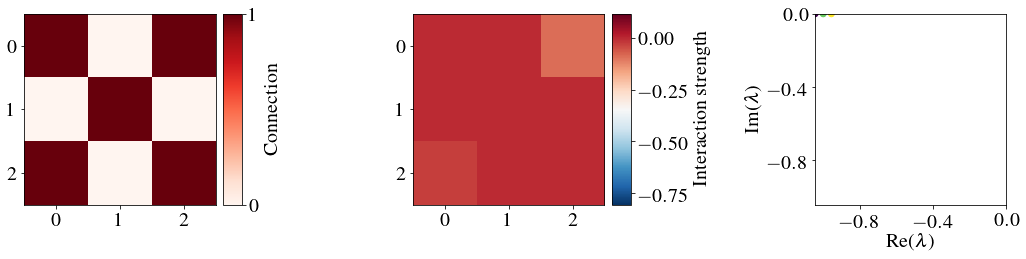

In [155]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))
A = np.array([[1, 0, 1],[0, 1, 0], [1, 0, 1]], dtype=bool)
plot_obj_1 = plot_adjacency_matrix(A, axs[0])
W = community_matrix_random_normal(A, sigma=0.1, d=1)
plot_obj_2 = plot_community_matrix(W, axs[1])
eigvs = spl.eigvals(W)
plot_obj_3 = scatter_plot_eigenvalues(eigvs, axs[2])
fig.tight_layout()

## Robert May's analysis

Robert May's model is just a simple linear model:

$\frac{d\mathbf{x}}{dt} = \mathbf{Ax}$.

Here, $\mathbf{A}$ is an $N \times N$ random matrix where:
- each off-diagonal element is non-zero with a probability $C$, and is sampled from a normal distribution $\sim \mathcal{N}(0,\sigma^2)$
- each diagonal element has a constant negative value of $-d$ 

May showed that the system become unstable and $\max Re(\lambda)$ becomes positive when $d > \sigma \sqrt{NC}$

In [156]:
# generate adjacency matrix defining connectivity

def adjacency_matrix_random(C, N):
    """
    Function that generates an adjacency matrix for a random graph, where each link has a probability C of being present
    
    Input:
    1. C: probability that the off-diagonal elements of the adjacency matrix is non-zero
    2. N: size of the square matrix
    
    Output:
    3. adj_mat: The function returns the adjacency matrix
    """
    # ensure that the value of C is a fraction
    assert C >= 0.0 and C <= 1.0, "The input probability C to the function has to be a fraction"
    
    # convert the elements to 1 with probability C
    adj_mat = np.zeros([N,N], dtype=bool)
    adj_mat = (np.random.random([N,N]) <= C)
    adj_mat[np.diag_indices_from(adj_mat)] = True
    return adj_mat

In [157]:
# generate final community matrix sampling from the random normal distribution

def community_matrix_random_normal(adj_mat, sigma, d):
    """
    Function that generates a random community matrix of species-species interactions, where each element is drawn from
    a zero-mean normal distribution with variance sigma
    
    Input:
    1. adj_mat: Adjacency matrix 
    2. sigma: Variance of the gaussian distribution
    3. d: value of diagonal elements
    
    Output:
    1. W: Community matrix of interactions
    """
    
    shape = np.shape(adj_mat)
    W = np.zeros(shape, dtype=float)
    
    # Sample off-diagonal elements from a gaussian distribution
    non_zero_elements = np.sum(adj_mat)
    W[adj_mat] = sigma*np.random.randn(non_zero_elements)
    
    # Diagonal elements are set to a fixed value
    W[np.diag_indices_from(W)] = -d
    
    return W

### Plot of eigenvalue spectrum

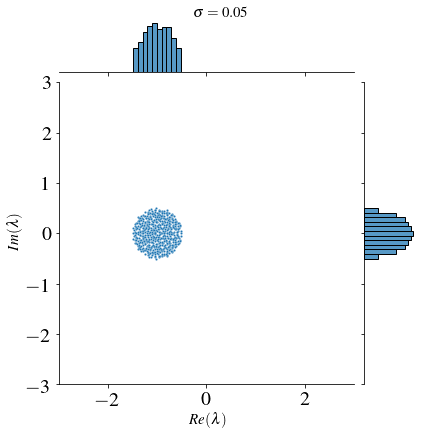

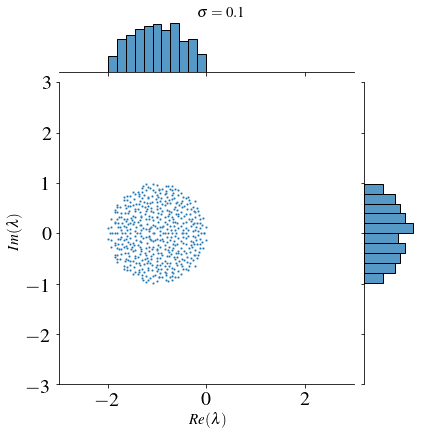

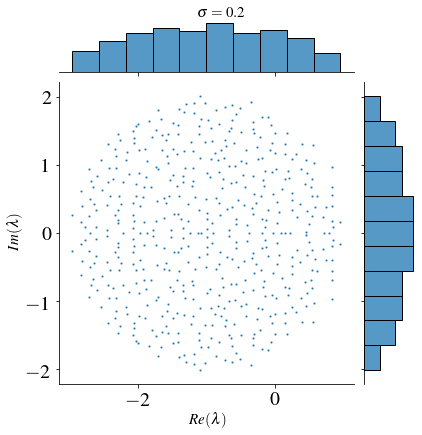

In [188]:
# Scatter plot of eigenvalues for different values of sigma

# Size of the ecosystem
N = 500
# Probability of connection between a pair of species
C = 0.2
# strength of self regulation
d = 1

# adjacency matrix
adj_mat = adjacency_matrix_random(C, N)

# Stability: sigma < d/sqrt(NC)

sigma = 0.05
W = community_matrix_random_normal(adj_mat, sigma, d)

eigvs = spl.eigvals(W)
p = sns.jointplot(x=np.real(eigvs), y=np.imag(eigvs), s=5)
p.fig.suptitle(r"$\sigma = 0.05$", fontsize=15)
p.set_axis_labels('$Re(\lambda)$', '$Im(\lambda)$', fontsize=15)
p.ax_marg_x.set_xlim(-3, 3)
p.ax_marg_y.set_ylim(-3, 3)

# Cusp of instability: sigma = d/sqrt(NC)

sigma = 0.1
W = community_matrix_random_normal(adj_mat, sigma, d)
eigvs = spl.eigvals(W)
p = sns.jointplot(x=np.real(eigvs), y=np.imag(eigvs), s=5)
p.fig.suptitle(r"$\sigma = 0.1$", fontsize=15)
p.set_axis_labels('$Re(\lambda)$', '$Im(\lambda)$', fontsize=15)
p.ax_marg_x.set_xlim(-3, 3)
p.ax_marg_y.set_ylim(-3, 3)

# Instability: sigma > d/sqrt(NC)

sigma = 0.2
W = community_matrix_random_normal(adj_mat, sigma, d)
eigvs = spl.eigvals(W)
p = sns.jointplot(x=np.real(eigvs), y=np.imag(eigvs), s=5)
p.fig.suptitle(r"$\sigma = 0.2$", fontsize=15)
p.set_axis_labels('$Re(\lambda)$', '$Im(\lambda)$', fontsize=15)

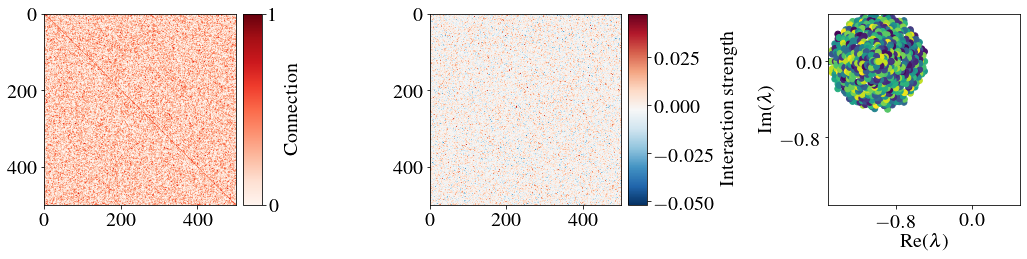

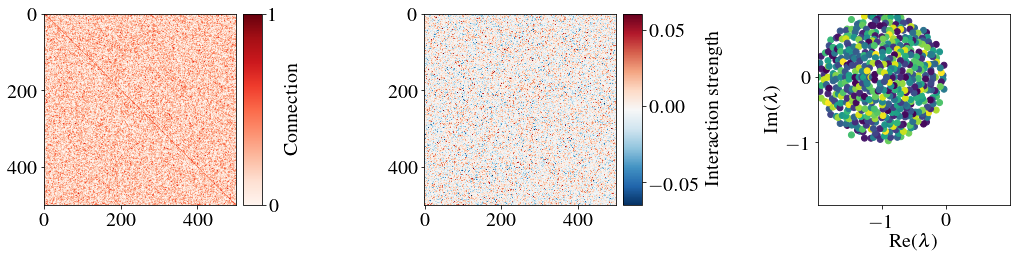

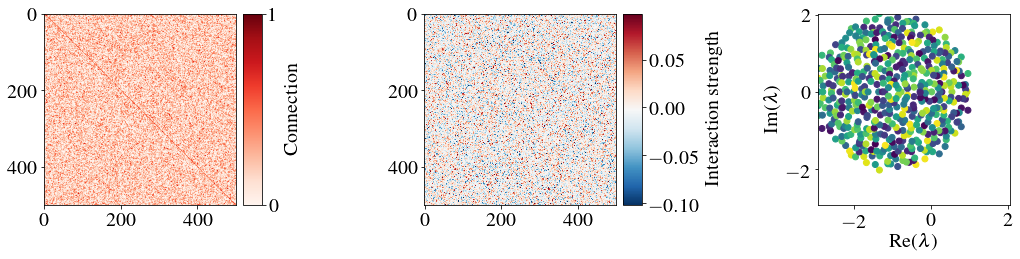

In [158]:
# Size of the ecosystem
N = 500
# Probability of connection between a pair of species
C = 0.2
# strength of self regulation
d = 1

A = adjacency_matrix_random(C, N)

sigma = 0.05
fig, axs = plt.subplots(1, 3, figsize=(15,4))
plot_obj_1 = plot_adjacency_matrix(A, axs[0])
W = community_matrix_random_normal(A, sigma=sigma, d=d)
plot_obj_2 = plot_community_matrix(W, axs[1])
eigvs = spl.eigvals(W)
plot_obj_3 = scatter_plot_eigenvalues(eigvs, axs[2])
fig.tight_layout()

sigma = 0.1
fig, axs = plt.subplots(1, 3, figsize=(15,4))
plot_obj_1 = plot_adjacency_matrix(A, axs[0])
W = community_matrix_random_normal(A, sigma=sigma, d=d)
plot_obj_2 = plot_community_matrix(W, axs[1])
eigvs = spl.eigvals(W)
plot_obj_3 = scatter_plot_eigenvalues(eigvs, axs[2])
fig.tight_layout()

sigma = 0.2
fig, axs = plt.subplots(1, 3, figsize=(15,4))
plot_obj_1 = plot_adjacency_matrix(A, axs[0])
W = community_matrix_random_normal(A, sigma=sigma, d=d)
plot_obj_2 = plot_community_matrix(W, axs[1])
eigvs = spl.eigvals(W)
plot_obj_3 = scatter_plot_eigenvalues(eigvs, axs[2])
fig.tight_layout()

### Plot of N vs. C at instability

In [ ]:
# For different values of N, find the C for which the maximum real part of the largest eigenvalue is 0

## Predator-Prey Models

In [159]:
def adjacency_matrix_paired(C, N):
    """
    Function that generates an adjacency matrix for a random graph, where each link has a probability C of being present.
    In addition, this also imposes the constraint that if a link between i and j exists, then a link between j and i 
    exists as well
    
    Input:
    1. C: probability that a pair of off-diagonal elements of the adjacency matrix is non-zero
    2. N: size of the square matrix
    
    Output:
    1. adj_mat: adjacency matrix of zeros and ones
    """
    # ensure that the value of C is a fraction
    assert C >= 0.0 and C <= 1.0, "The input probability C to the function has to be a fraction"
    
    # generate pairs of non-zero off diagonal elements with probability C
    size_of_upper_triangle = int(N*(N-1)/2)
    upper_triangular_entries = np.random.random(size_of_upper_triangle)
    
    # construct adjacency matrix by making an upper triangular matrix of the above list
    adj_mat = np.zeros([N,N], dtype=bool)
    adj_mat[np.triu_indices(N, k=1)] = (upper_triangular_entries <= C)
    adj_mat = adj_mat + adj_mat.transpose()
    adj_mat[np.diag_indices_from(adj_mat)] = True
    
    return adj_mat

In [160]:
def community_matrix_random_predator_prey(adj_mat, sigma, d):
    """
    Function that generates a random community matrix of predator-prey interactions. The pairs of off-diagonal elements
    W_ij and W_ji are each sampled independently from a distribution of |X| where X ~ normal(0,sigma). It is also ensured
    that W_ij and W_ji have opposite signs
    
    Input:
    1. adj_mat: Adjacency matrix 
    2. sigma: Variance of the gaussian distribution
    3. d: value of diagonal elements
    
    Output:
    1. W: Community matrix of interactions
    """
    # Initialize the community matrix
    shape = np.shape(adj_mat)
    N = shape[0]
    sign_matrix = np.zeros(shape, dtype=int)
    W = np.zeros(shape, dtype=float)
    
    # Sample a list of elements as |X| where X is drawn from a gaussian distribution
    number_of_non_zero_elements = np.sum(adj_mat)
    non_zero_elements = sigma*np.random.randn(number_of_non_zero_elements)
    W[adj_mat] = np.abs(non_zero_elements)
    # generate a random string of +1 and -1 for the signs of the upper diagonal elements
    sign_matrix[adj_mat] = 2*(np.random.binomial(size=number_of_non_zero_elements, n=1, p= 0.5) - 0.5)
    sign_matrix[np.tril_indices(N)] = 0
    sign_matrix = sign_matrix - sign_matrix.transpose()
    # non-zero off-diagonal elements of W matrix are obtained by multiplying the above two matrices
    W[adj_mat] = np.multiply(W[adj_mat], sign_matrix[adj_mat])
    
    # Diagonal elements are set to a fixed value
    W[np.diag_indices_from(W)] = -d
    
    return W

For predator prey models, the stability criterion is $\sqrt{NC} < \frac{d}{\sigma} \frac{\pi}{\pi -2}$

(-6.0, 6.0)

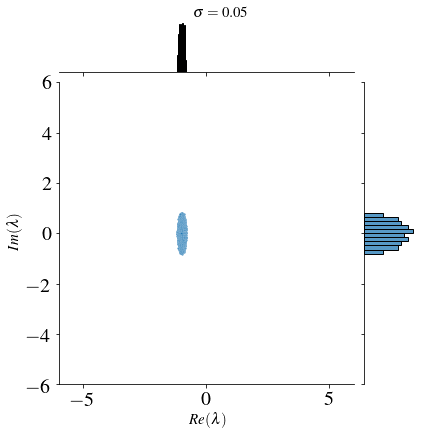

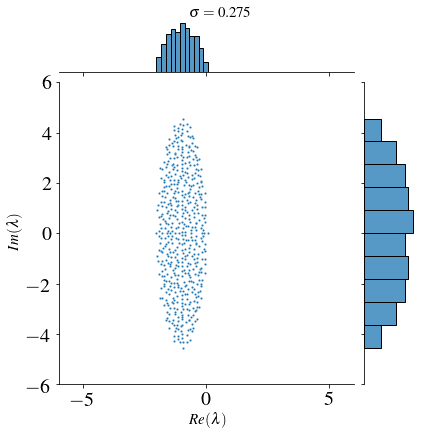

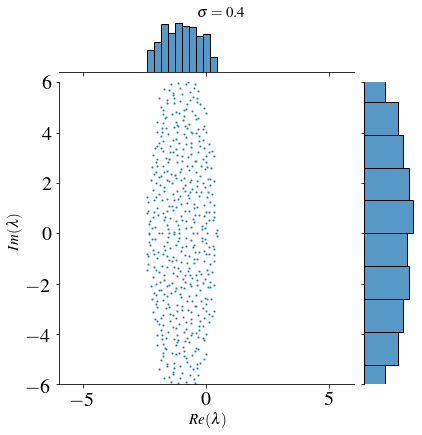

In [207]:
# Scatter plot of eigenvalues for different values of sigma

# Size of the ecosystem
N = 500
# Probability of connection between a pair of species
C = 0.2
# strength of self regulation
d = 1


# adjacency matrix
adj_mat = adjacency_matrix_paired(C, N)

# Stability: sigma < d/sqrt(NC)

sigma = 0.05
W = community_matrix_random_predator_prey(adj_mat, sigma, d)
eigvs = spl.eigvals(W)
p = sns.jointplot(x=np.real(eigvs), y=np.imag(eigvs), s=5)
p.fig.suptitle(r"$\sigma = 0.05$", fontsize=15)
p.set_axis_labels('$Re(\lambda)$', '$Im(\lambda)$', fontsize=15)
p.ax_marg_x.set_xlim(-6, 6)
p.ax_marg_y.set_ylim(-6, 6)

# Cusp of instability: sigma = d/sqrt(NC)

sigma = 0.275
W = community_matrix_random_predator_prey(adj_mat, sigma, d)
eigvs = spl.eigvals(W)
p = sns.jointplot(x=np.real(eigvs), y=np.imag(eigvs), s=5)
p.fig.suptitle(r"$\sigma = 0.275$", fontsize=15)
p.set_axis_labels('$Re(\lambda)$', '$Im(\lambda)$', fontsize=15)
p.ax_marg_x.set_xlim(-6, 6)
p.ax_marg_y.set_ylim(-6, 6)

# Instability: sigma > sigma_cutoff

sigma = 0.4
W = community_matrix_random_predator_prey(adj_mat, sigma, d)
eigvs = spl.eigvals(W)
p = sns.jointplot(x=np.real(eigvs), y=np.imag(eigvs), s=5)
p.fig.suptitle(r"$\sigma = 0.4$", fontsize=15)
p.set_axis_labels('$Re(\lambda)$', '$Im(\lambda)$', fontsize=15)
p.ax_marg_x.set_xlim(-6, 6)
p.ax_marg_y.set_ylim(-6, 6)

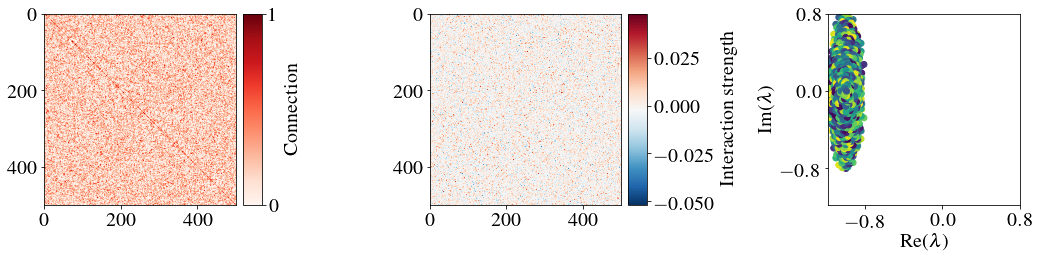

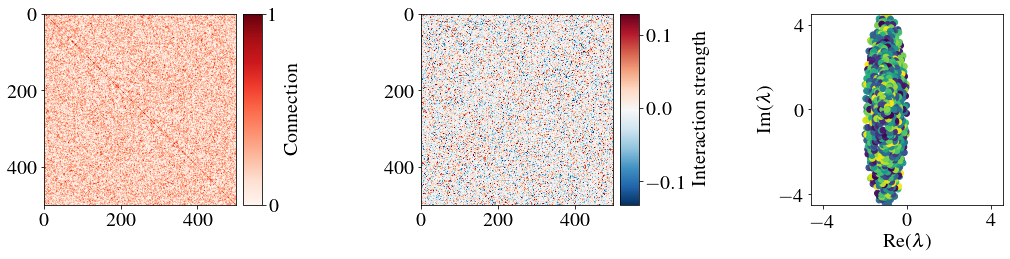

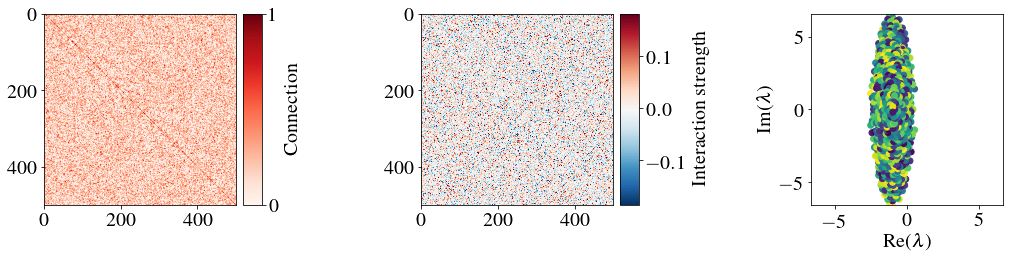

In [161]:
# Size of the ecosystem
N = 500
# Probability of connection between a pair of species
C = 0.2
# strength of self regulation
d = 1

A = adjacency_matrix_paired(C, N)

sigma = 0.05
fig, axs = plt.subplots(1, 3, figsize=(15,4))
plot_obj_1 = plot_adjacency_matrix(A, axs[0])
W = community_matrix_random_predator_prey(A, sigma=sigma, d=d)
plot_obj_2 = plot_community_matrix(W, axs[1])
eigvs = spl.eigvals(W)
plot_obj_3 = scatter_plot_eigenvalues(eigvs, axs[2])
fig.tight_layout()

sigma = 0.275
fig, axs = plt.subplots(1, 3, figsize=(15,4))
plot_obj_1 = plot_adjacency_matrix(A, axs[0])
W = community_matrix_random_predator_prey(A, sigma=sigma, d=d)
plot_obj_2 = plot_community_matrix(W, axs[1])
eigvs = spl.eigvals(W)
plot_obj_3 = scatter_plot_eigenvalues(eigvs, axs[2])
fig.tight_layout()

sigma = 0.4
fig, axs = plt.subplots(1, 3, figsize=(15,4))
plot_obj_1 = plot_adjacency_matrix(A, axs[0])
W = community_matrix_random_predator_prey(A, sigma=sigma, d=d)
plot_obj_2 = plot_community_matrix(W, axs[1])
eigvs = spl.eigvals(W)
plot_obj_3 = scatter_plot_eigenvalues(eigvs, axs[2])
fig.tight_layout()

## Mutualism

In [142]:
def community_matrix_random_mutualism(adj_mat, sigma, d):
    """
    Function that generates a random community matrix for mutualistic interactions. The pairs of off-diagonal elements
    W_ij and W_ji are each sampled independently from a distribution of |X| where X ~ normal(0,sigma). It is also ensured
    that W_ij and W_ji have +ve sign
    
    Input:
    1. adj_mat: Adjacency matrix 
    2. sigma: Variance of the gaussian distribution
    3. d: value of diagonal elements
    
    Output:
    1. W: Community matrix of interactions
    """
    # Initialize the community matrix
    shape = np.shape(adj_mat)
    W = np.zeros(shape, dtype=float)
    
    # Sample a list of elements as |X| where X is drawn from a gaussian distribution
    number_of_non_zero_elements = np.sum(adj_mat)
    non_zero_elements = sigma*np.random.randn(number_of_non_zero_elements)
    W[adj_mat] = np.abs(non_zero_elements)
    
    # Diagonal elements are set to a fixed value
    W[np.diag_indices_from(W)] = -d
    
    return W

For mutualism models, the stability criterion is $(N-1)C< \frac{d}{\sigma} \sqrt{\frac{\pi}{2}}$

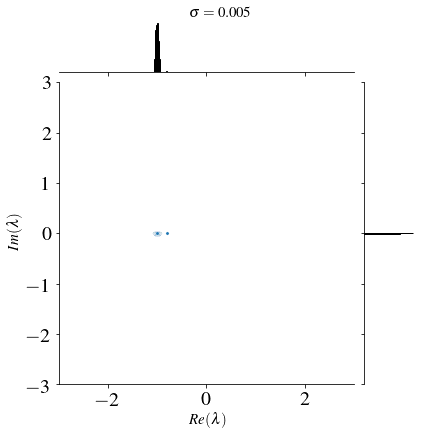

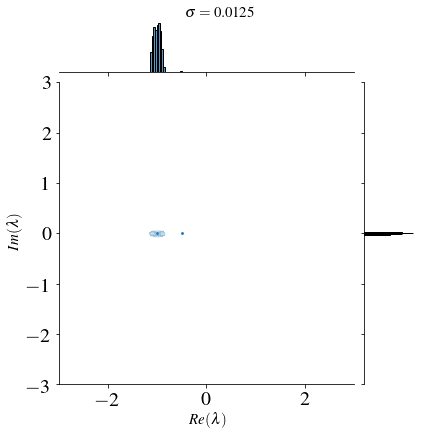

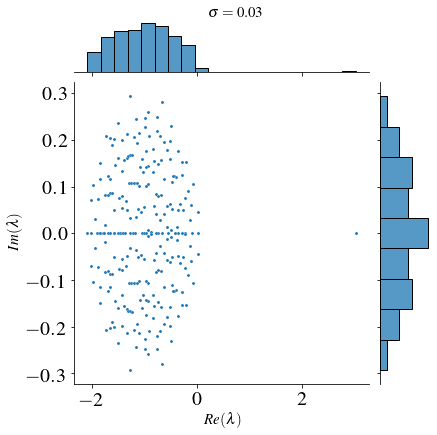

In [567]:
# Scatter plot of eigenvalues for different values of sigma

# Size of the ecosystem
N = 250
# Probability of connection between a pair of species
C = 0.2
# strength of self regulation
d = 1


# adjacency matrix
adj_mat = adjacency_matrix_paired(C, N)

# Stability: sigma < d/sqrt(NC)

sigma = 0.005
W = community_matrix_random_mutualism(adj_mat, sigma, d)
eigvs = spl.eigvals(W)
p = sns.jointplot(x=np.real(eigvs), y=np.imag(eigvs), s=10)
p.fig.suptitle(r"$\sigma = 0.005$", fontsize=15)
p.set_axis_labels('$Re(\lambda)$', '$Im(\lambda)$', fontsize=15)
p.ax_marg_x.set_xlim(-3, 3)
p.ax_marg_y.set_ylim(-3, 3)

# Cusp of instability: sigma = sigma_cutoff

sigma = 0.0125
W = community_matrix_random_mutualism(adj_mat, sigma, d)
eigvs = spl.eigvals(W)
p = sns.jointplot(x=np.real(eigvs), y=np.imag(eigvs), s=10)
p.fig.suptitle(r"$\sigma = 0.0125$", fontsize=15)
p.set_axis_labels('$Re(\lambda)$', '$Im(\lambda)$', fontsize=15)
p.ax_marg_x.set_xlim(-3, 3)
p.ax_marg_y.set_ylim(-3, 3)

# Instability: sigma > d/sqrt(NC)

sigma = 0.1
W = community_matrix_random_mutualism(adj_mat, sigma, d)
eigvs = spl.eigvals(W)
p = sns.jointplot(x=np.real(eigvs), y=np.imag(eigvs), s=10)
p.fig.suptitle(r"$\sigma = 0.03$", fontsize=15)
p.set_axis_labels('$Re(\lambda)$', '$Im(\lambda)$', fontsize=15)
# p.ax_marg_x.set_xlim(-3, 3)
# p.ax_marg_y.set_ylim(-3, 3)

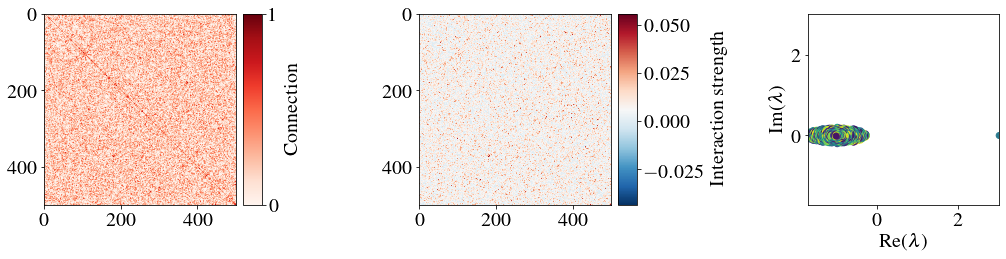

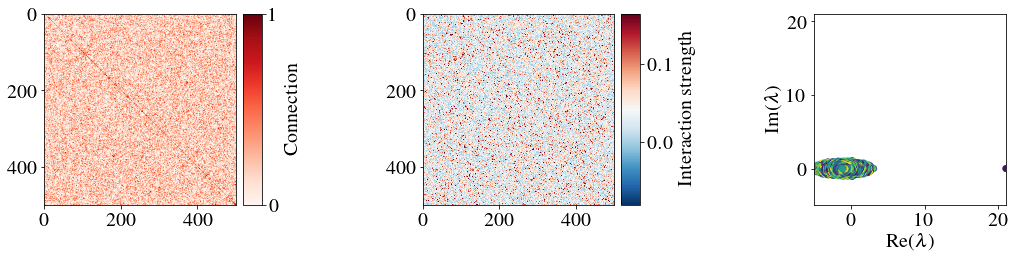

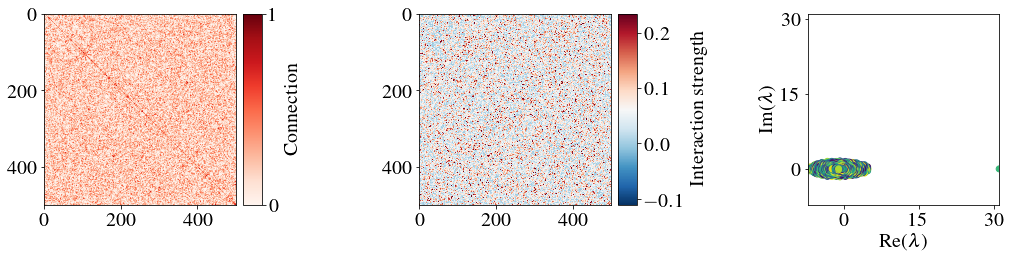

In [162]:
# Size of the ecosystem
N = 500
# Probability of connection between a pair of species
C = 0.2
# strength of self regulation
d = 1

A = adjacency_matrix_paired(C, N)

sigma = 0.05
fig, axs = plt.subplots(1, 3, figsize=(15,4))
plot_obj_1 = plot_adjacency_matrix(A, axs[0])
W = community_matrix_random_mutualism(A, sigma=sigma, d=d)
plot_obj_2 = plot_community_matrix(W, axs[1])
eigvs = spl.eigvals(W)
plot_obj_3 = scatter_plot_eigenvalues(eigvs, axs[2])
fig.tight_layout()

sigma = 0.275
fig, axs = plt.subplots(1, 3, figsize=(15,4))
plot_obj_1 = plot_adjacency_matrix(A, axs[0])
W = community_matrix_random_mutualism(A, sigma=sigma, d=d)
plot_obj_2 = plot_community_matrix(W, axs[1])
eigvs = spl.eigvals(W)
plot_obj_3 = scatter_plot_eigenvalues(eigvs, axs[2])
fig.tight_layout()

sigma = 0.4
fig, axs = plt.subplots(1, 3, figsize=(15,4))
plot_obj_1 = plot_adjacency_matrix(A, axs[0])
W = community_matrix_random_mutualism(A, sigma=sigma, d=d)
plot_obj_2 = plot_community_matrix(W, axs[1])
eigvs = spl.eigvals(W)
plot_obj_3 = scatter_plot_eigenvalues(eigvs, axs[2])
fig.tight_layout()

## Competition

In [145]:
def community_matrix_random_competition(adj_mat, sigma, d):
    """
    Function that generates a random community matrix for competitive interactions. The pairs of off-diagonal elements
    W_ij and W_ji are each sampled independently from a distribution of |X| where X ~ normal(0,sigma). It is also ensured
    that W_ij and W_ji have -ve sign
    
    Input:
    1. adj_mat: Adjacency matrix 
    2. sigma: Variance of the gaussian distribution
    3. d: value of diagonal elements
    
    Output:
    4. W: Community matrix of interactions
    """
    # Initialize the community matrix
    shape = np.shape(adj_mat)
    W = np.zeros(shape, dtype=float)
    
    # Sample a list of elements as |X| where X is drawn from a gaussian distribution
    number_of_non_zero_elements = np.sum(adj_mat)
    non_zero_elements = sigma*np.random.randn(number_of_non_zero_elements)
    W[adj_mat] = -np.abs(non_zero_elements)
    
    # Diagonal elements are set to a fixed value
    W[np.diag_indices_from(W)] = -d
    
    return W

For competition models, the stability criterion is $\sqrt{NC}\Big(1+\frac{2-2C}{\pi-2C}\Big)\sqrt{\frac{\pi-2C}{\pi}} + C\sqrt{\frac{2}{\pi}}< \frac{d}{\sigma} $

0.06687560345818716


(-3.0, 3.0)

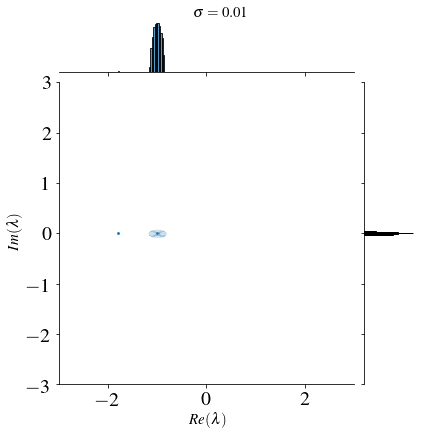

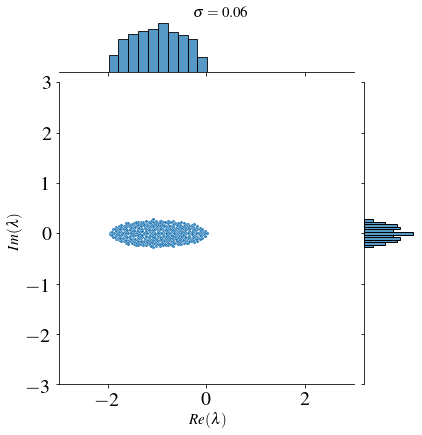

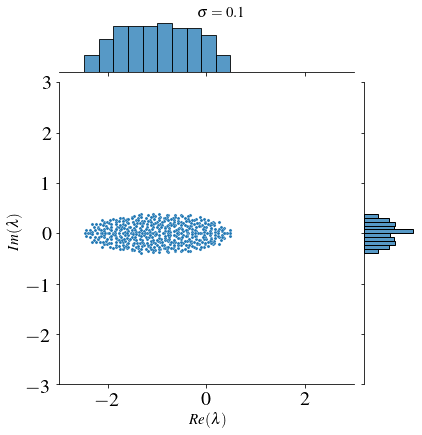

In [219]:
# Scatter plot of eigenvalues for different values of sigma

# Size of the ecosystem
N = 500
# Probability of connection between a pair of species
C = 0.2
# strength of self regulation
d = 1

sigma_cutoff = d/((N*C)**0.5*(1+(2-2*C)/(np.pi-2*C))*((np.pi-2*C)/np.pi)**0.5+C*(2/np.pi)**0.5)

# adjacency matrix
adj_mat = adjacency_matrix_paired(C, N)

# Stability: sigma < d/sqrt(NC)

sigma = 0.01
W = community_matrix_random_competition(adj_mat, sigma, d)
eigvs = spl.eigvals(W)
p = sns.jointplot(x=np.real(eigvs), y=np.imag(eigvs), s=10)
p.fig.suptitle(r"$\sigma = 0.01$", fontsize=15)
p.set_axis_labels('$Re(\lambda)$', '$Im(\lambda)$', fontsize=15)
p.ax_marg_x.set_xlim(-3, 3)
p.ax_marg_y.set_ylim(-3, 3)

# Cusp of instability: sigma = sigma_cutoff

sigma = sigma_cutoff
W = community_matrix_random_competition(adj_mat, sigma, d)
eigvs = spl.eigvals(W)
p = sns.jointplot(x=np.real(eigvs), y=np.imag(eigvs), s=10)
p.fig.suptitle(r"$\sigma = 0.06$", fontsize=15)
p.set_axis_labels('$Re(\lambda)$', '$Im(\lambda)$', fontsize=15)
p.ax_marg_x.set_xlim(-3, 3)
p.ax_marg_y.set_ylim(-3, 3)

# Instability: sigma > d/sqrt(NC)

sigma = 0.1
W = community_matrix_random_competition(adj_mat, sigma, d)
eigvs = spl.eigvals(W)
p = sns.jointplot(x=np.real(eigvs), y=np.imag(eigvs), s=10)
p.fig.suptitle(r"$\sigma = 0.1$", fontsize=15)
p.set_axis_labels('$Re(\lambda)$', '$Im(\lambda)$', fontsize=15)
p.ax_marg_x.set_xlim(-3, 3)
p.ax_marg_y.set_ylim(-3, 3)

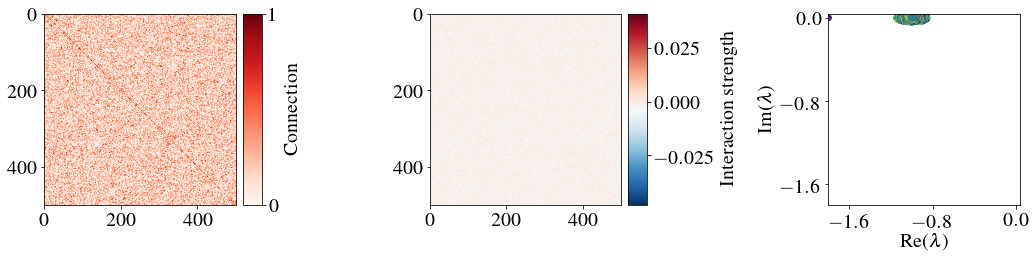

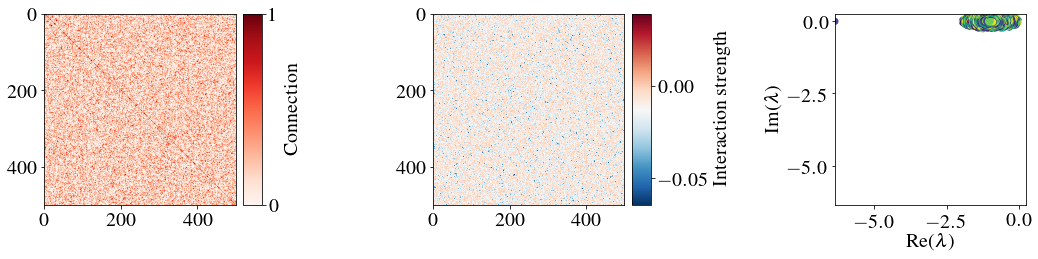

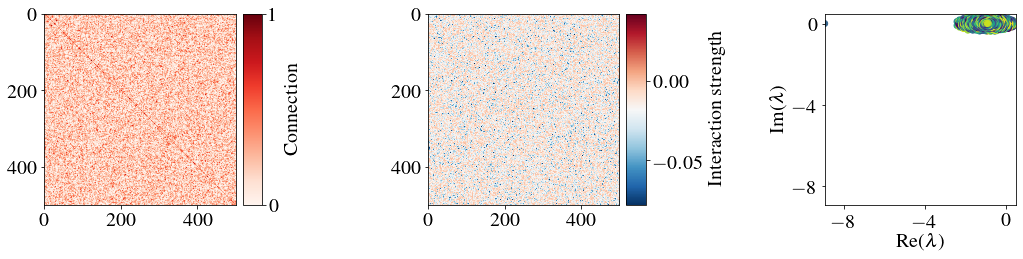

In [163]:
# Size of the ecosystem
N = 500
# Probability of connection between a pair of species
C = 0.2
# strength of self regulation
d = 1

A = adjacency_matrix_paired(C, N)

sigma_cutoff = d/((N*C)**0.5*(1+(2-2*C)/(np.pi-2*C))*((np.pi-2*C)/np.pi)**0.5+C*(2/np.pi)**0.5)

sigma = 0.01
fig, axs = plt.subplots(1, 3, figsize=(15,4))
plot_obj_1 = plot_adjacency_matrix(A, axs[0])
W = community_matrix_random_competition(A, sigma=sigma, d=d)
plot_obj_2 = plot_community_matrix(W, axs[1])
eigvs = spl.eigvals(W)
plot_obj_3 = scatter_plot_eigenvalues(eigvs, axs[2])
fig.tight_layout()

sigma = sigma_cutoff
fig, axs = plt.subplots(1, 3, figsize=(15,4))
plot_obj_1 = plot_adjacency_matrix(A, axs[0])
W = community_matrix_random_competition(A, sigma=sigma, d=d)
plot_obj_2 = plot_community_matrix(W, axs[1])
eigvs = spl.eigvals(W)
plot_obj_3 = scatter_plot_eigenvalues(eigvs, axs[2])
fig.tight_layout()

sigma = 0.1
fig, axs = plt.subplots(1, 3, figsize=(15,4))
plot_obj_1 = plot_adjacency_matrix(A, axs[0])
W = community_matrix_random_competition(A, sigma=sigma, d=d)
plot_obj_2 = plot_community_matrix(W, axs[1])
eigvs = spl.eigvals(W)
plot_obj_3 = scatter_plot_eigenvalues(eigvs, axs[2])
fig.tight_layout()

## Mixture of competition and mutualism

In [147]:
def community_matrix_random_mixture(adj_mat, sigma, d):
    """
    Function that generates a random community matrix of a mixture of competition and mutualistic interactions. 
    The pairs of off-diagonal elements W_ij and W_ji are each sampled independently from a distribution of |X| 
    where X ~ normal(0,sigma). The signs of W_ij and W_ji are randomly of same sign or opposite sign
    
    Input:
    1. adj_mat: Adjacency matrix 
    2. sigma: Variance of the gaussian distribution
    3. d: value of diagonal elements
    
    Output:
    1. W: Community matrix of interactions
    """
    # Initialize the community matrix
    shape = np.shape(adj_mat)
    N = shape[0]
    sign_matrix = np.zeros(shape, dtype=int)
    W = np.zeros(shape, dtype=float)
    
    # Sample a list of elements as |X| where X is drawn from a gaussian distribution
    number_of_non_zero_elements = np.sum(adj_mat)
    non_zero_elements = sigma*np.random.randn(number_of_non_zero_elements)
    W[adj_mat] = np.abs(non_zero_elements)
    # generate a random string of +1 and -1 for the signs of the upper diagonal elements
    sign_matrix[adj_mat] = 2*(np.random.binomial(size=number_of_non_zero_elements, n=1, p= 0.5) - 0.5)
    sign_matrix[np.tril_indices(N)] = 0
    sign_matrix = sign_matrix + sign_matrix.transpose()
    # non-zero off-diagonal elements of W matrix are obtained by multiplying the above two matrices
    W[adj_mat] = np.multiply(W[adj_mat], sign_matrix[adj_mat])
    
    # Diagonal elements are set to a fixed value
    W[np.diag_indices_from(W)] = -d
    
    return W

For mixture models, the stability criterion is $\sqrt{NC}< \frac{d}{\sigma} \frac{\pi}{\pi + 2}$

(-3.0, 3.0)

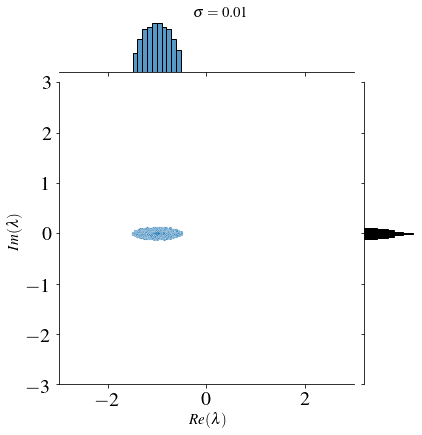

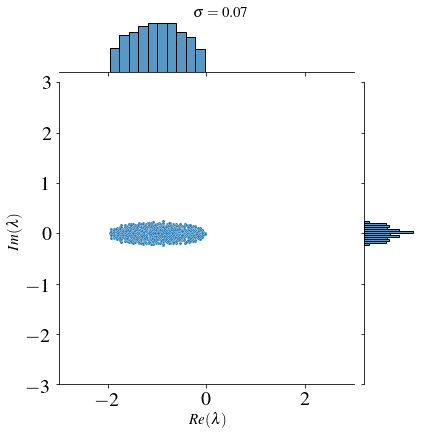

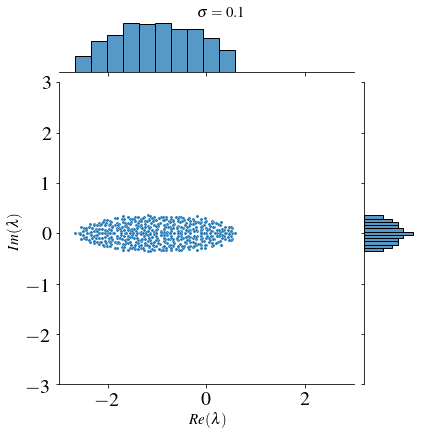

In [234]:
# Scatter plot of eigenvalues for different values of sigma

# Size of the ecosystem
N = 500
# Probability of connection between a pair of species
C = 0.2
# strength of self regulation
d = 1

sigma_cutoff = d/((N*C)**0.5)*(np.pi/(np.pi+2))


# adjacency matrix
adj_mat = adjacency_matrix_paired(C, N)

# Stability: sigma < d/sqrt(NC)

sigma = 0.03
W = community_matrix_random_mixture(adj_mat, sigma, d)
eigvs = spl.eigvals(W)
p = sns.jointplot(x=np.real(eigvs), y=np.imag(eigvs), s=10)
p.fig.suptitle(r"$\sigma = 0.01$", fontsize=15)
p.set_axis_labels('$Re(\lambda)$', '$Im(\lambda)$', fontsize=15)
p.ax_marg_x.set_xlim(-3, 3)
p.ax_marg_y.set_ylim(-3, 3)

# Cusp of instability: sigma = sigma_cutoff

sigma = sigma_cutoff
W = community_matrix_random_mixture(adj_mat, sigma, d)
eigvs = spl.eigvals(W)
p = sns.jointplot(x=np.real(eigvs), y=np.imag(eigvs), s=10)
p.fig.suptitle(r"$\sigma = 0.07$", fontsize=15)
p.set_axis_labels('$Re(\lambda)$', '$Im(\lambda)$', fontsize=15)
p.ax_marg_x.set_xlim(-3, 3)
p.ax_marg_y.set_ylim(-3, 3)

# Instability: sigma > d/sqrt(NC)

sigma = 0.1
W = community_matrix_random_mixture(adj_mat, sigma, d)
eigvs = spl.eigvals(W)
p = sns.jointplot(x=np.real(eigvs), y=np.imag(eigvs), s=10)
p.fig.suptitle(r"$\sigma = 0.1$", fontsize=15)
p.set_axis_labels('$Re(\lambda)$', '$Im(\lambda)$', fontsize=15)
p.ax_marg_x.set_xlim(-3, 3)
p.ax_marg_y.set_ylim(-3, 3)

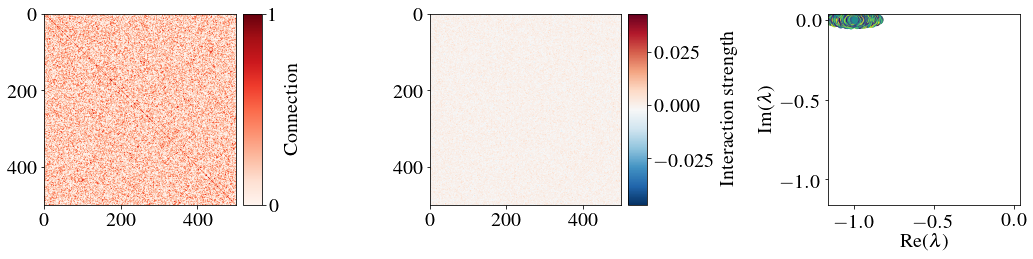

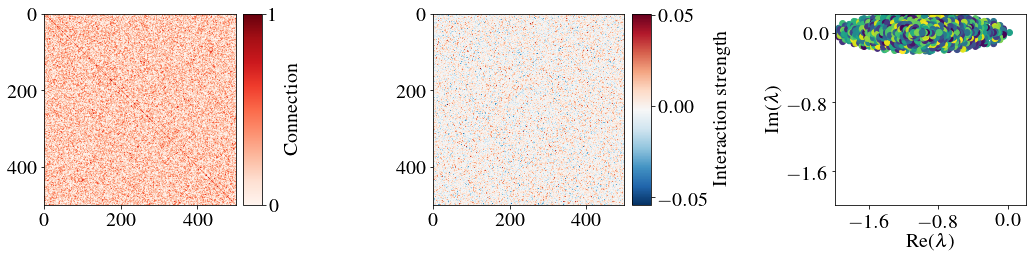

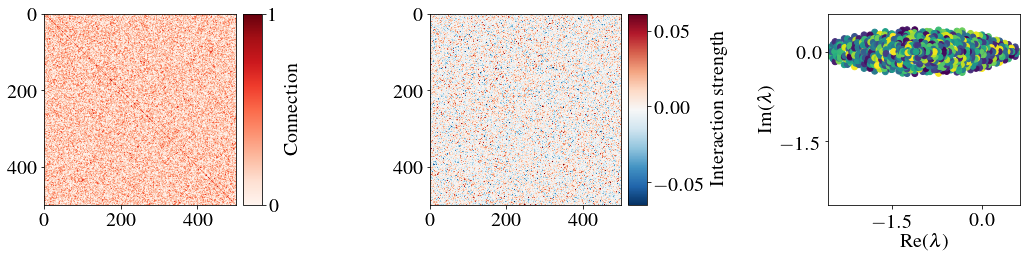

In [164]:
# Size of the ecosystem
N = 500
# Probability of connection between a pair of species
C = 0.2
# strength of self regulation
d = 1

A = adjacency_matrix_paired(C, N)

sigma_cutoff = d/((N*C)**0.5)*(np.pi/(np.pi+2))

sigma = 0.01
fig, axs = plt.subplots(1, 3, figsize=(15,4))
plot_obj_1 = plot_adjacency_matrix(A, axs[0])
W = community_matrix_random_mixture(A, sigma=sigma, d=d)
plot_obj_2 = plot_community_matrix(W, axs[1])
eigvs = spl.eigvals(W)
plot_obj_3 = scatter_plot_eigenvalues(eigvs, axs[2])
fig.tight_layout()

sigma = sigma_cutoff
fig, axs = plt.subplots(1, 3, figsize=(15,4))
plot_obj_1 = plot_adjacency_matrix(A, axs[0])
W = community_matrix_random_mixture(A, sigma=sigma, d=d)
plot_obj_2 = plot_community_matrix(W, axs[1])
eigvs = spl.eigvals(W)
plot_obj_3 = scatter_plot_eigenvalues(eigvs, axs[2])
fig.tight_layout()

sigma = 0.1
fig, axs = plt.subplots(1, 3, figsize=(15,4))
plot_obj_1 = plot_adjacency_matrix(A, axs[0])
W = community_matrix_random_mixture(A, sigma=sigma, d=d)
plot_obj_2 = plot_community_matrix(W, axs[1])
eigvs = spl.eigvals(W)
plot_obj_3 = scatter_plot_eigenvalues(eigvs, axs[2])
fig.tight_layout()

## Cascade predator prey model

In [243]:
def community_matrix_random_cascade(adj_mat, sigma, d):
    """
    Function that generates a random community matrix of predator-prey interactions according to the cascade model. 
    Cascade model:
    The lower triangular elements W_ij are sampled from a distribution of |X| where X ~ normal(0,sigma). 
    The upper triangular element W_ji corresponding to the W_ij is sampled from the distribution of -|X| 
    where X ~ normal(0,sigma)
    
    Input:
    1. adj_mat: Adjacency matrix 
    2. sigma: Variance of the gaussian distribution
    3. d: value of diagonal elements
    
    Output:
    1. W: Community matrix of interactions
    """
    # Initialize the community matrix
    shape = np.shape(adj_mat)
    W = np.zeros(shape, dtype=float)
    
    # Sample a list of elements as |X| where X is drawn from a gaussian distribution for the lower triangle
    number_of_non_zero_elements = np.sum(adj_mat)
    non_zero_elements = sigma*np.random.randn(number_of_non_zero_elements)
    W[adj_mat] = np.abs(non_zero_elements)
    # make the lower triangle have +ve sign and the upper triangle have negative sign
    W[np.triu_indices_from(W)] = -1.0*W[np.triu_indices_from(W)] 
    
    # Diagonal elements are set to a fixed value
    W[np.diag_indices_from(W)] = -d
    
    return W

For cascade predator prey models, the stability criterion is $\sqrt{NC} < \frac{d}{\sigma} \frac{\pi}{\pi -2}$

(-6.0, 6.0)

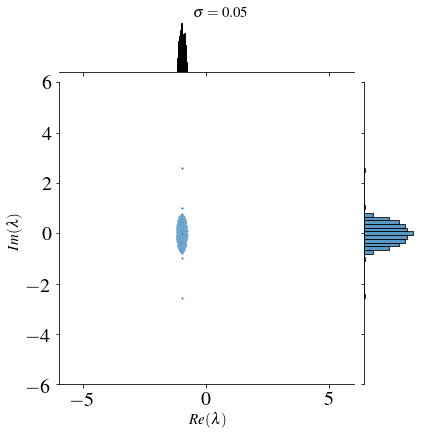

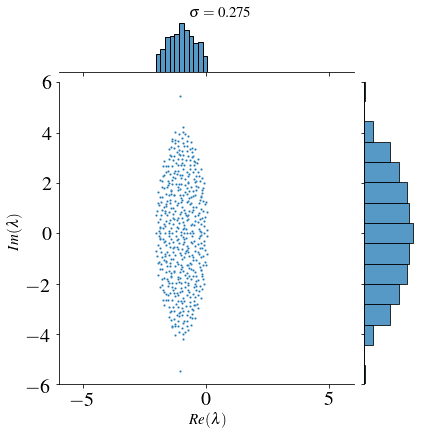

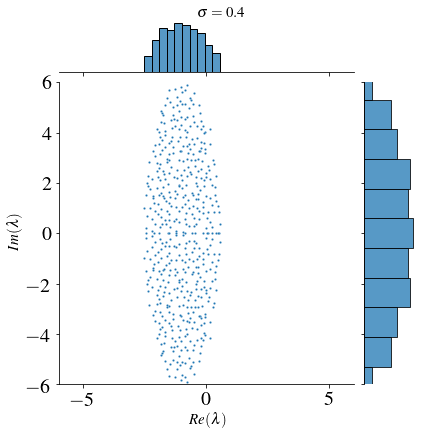

In [246]:
# Scatter plot of eigenvalues for different values of sigma

# Size of the ecosystem
N = 500
# Probability of connection between a pair of species
C = 0.2
# strength of self regulation
d = 1


# adjacency matrix
adj_mat = adjacency_matrix_paired(C, N)

# Stability: sigma < d/sqrt(NC)

sigma = 0.05
W = community_matrix_random_cascade(adj_mat, sigma, d)
eigvs = spl.eigvals(W)
p = sns.jointplot(x=np.real(eigvs), y=np.imag(eigvs), s=5)
p.fig.suptitle(r"$\sigma = 0.05$", fontsize=15)
p.set_axis_labels('$Re(\lambda)$', '$Im(\lambda)$', fontsize=15)
p.ax_marg_x.set_xlim(-6, 6)
p.ax_marg_y.set_ylim(-6, 6)

# Cusp of instability: sigma = d/sqrt(NC)

sigma = 0.275
W = community_matrix_random_cascade(adj_mat, sigma, d)
eigvs = spl.eigvals(W)
p = sns.jointplot(x=np.real(eigvs), y=np.imag(eigvs), s=5)
p.fig.suptitle(r"$\sigma = 0.275$", fontsize=15)
p.set_axis_labels('$Re(\lambda)$', '$Im(\lambda)$', fontsize=15)
p.ax_marg_x.set_xlim(-6, 6)
p.ax_marg_y.set_ylim(-6, 6)

# Instability: sigma > sigma_cutoff

sigma = 0.4
W = community_matrix_random_cascade(adj_mat, sigma, d)
eigvs = spl.eigvals(W)
p = sns.jointplot(x=np.real(eigvs), y=np.imag(eigvs), s=5)
p.fig.suptitle(r"$\sigma = 0.4$", fontsize=15)
p.set_axis_labels('$Re(\lambda)$', '$Im(\lambda)$', fontsize=15)
p.ax_marg_x.set_xlim(-6, 6)
p.ax_marg_y.set_ylim(-6, 6)

## Niche predator-prey model

In [10]:
# generate adjacency matrix defining connectivity

def adjacency_matrix_niche(C, N, tolerance=0.01):
    """
    Function that generates an adjacency matrix for a niche connectivity model.
    Niche Model (as described in: https://rdrr.io/github/elsander/PredictImportance/src/R/BuildNiche.R)
    1. In a niche model, each species is assigned a niche value (ni), which is sampled uniformly between [0,1]
    2. This nice value (ni) is used to compute a niche radius (ri) where ri = X*ni, where X ~ Beta(1,1/C-1)
       The above method also ensures that the connectance of the graph is C on average. There might be fluctuations about 
       the mean value of C for small graphs
    3. A niche center (ci) is chosen for each species by uniformly sampling the interval [ri/2, min(ni, 1-ri/2)].
       The point is to ensure that the interval [ci-ri/2, ci+ri/2] lies entirely within [0,1] and is centered 
       around ni on average whenever possible.
    4. Each species i preys upon all species j whose niche values nj belong to the interval [ci-ri/2, ci+ri/2]
    5. Using the above model, construct a matrix A_ij where A_ij = 1 if i is a prey of j.
    6. Construct a sign matrix P = -A + A'
    7. Finally, the community matrix is obtained by multiplying P with a random matrix of elements sampled from |X|
       where X ~ normal(0,sigma)
    
    Input:
    1. C: probability that the off-diagonal elements of the adjacency matrix is non-zero
    2. N: size of the square matrix
    
    Output:
    1. adj_mat: The function returns the adjacency matrix along with sign. Note that this is a matrix that contains
                +1, -1 and 0. 
    """
    # ensure that the value of C is a fraction
    assert C >= 0.0 and C <= 1.0, "The input probability C to the function has to be a fraction"
    
    # Initialize adjacency matrix
    adj_mat = np.zeros([N,N], dtype=int)
    # 1. assign niche values
    n = np.random.random(N)
    
    # this loop is to generate different adjacency matrices and accept one that best conforms to the connectance value C
    accept = False
    iter_max = 100
    counter = 0
    while (not accept) and (counter < iter_max):
        # 2. compute niche radii
        beta = np.random.beta(a=1.0, b=1.0/(0.5*C)-1.0, size=N)
        r = np.multiply(beta, n)
        # 3. get niche center for each niche
        interval_lower_bound = 0.5*r
        interval_upper_bound = np.min([n,1.0-0.5*r])
        c = np.multiply(np.random.random(N), interval_upper_bound-interval_lower_bound) + interval_lower_bound
        # 4. make all species in the interval [ci-ri/2,ci+ri/2] as the prey for predator i
        for i in range(N):
            prey_indices = (n>c[i]-0.5*r[i]) & (n<c[i]+0.5*r[i])
            adj_mat[prey_indices,i] = 1
        # do quality control to check that the connectance C is the desired value C
        counter = counter+1
        if np.abs(np.sum(np.abs(adj_mat))/(N*(N-1.0)/2.0) - C) < tolerance:
            # print('great')
            accept = True
    if counter == iter_max:
        print("Warning: the adjacency matrix may not be correct!")
        
    # 6. construct sign matrix
    adj_mat = adj_mat.transpose() - adj_mat
    
    return adj_mat

In [11]:
def community_matrix_random_niche(adj_mat, sigma, d):
    """
    Function that generates a random community matrix of predator-prey interactions according to the niche model. 
    Niche model:
    The adjacency matrix is generated corresponding the niche algorithm
    The individual non-zero elements of the community matrix are generated according to the distribution |X|
    where X ~ normal(0,sigma) and multiplying them with the appropriate sign in the signed adjacency matrix
    
    Input:
    1. adj_mat: Adjacency matrix. Note that the adjacency matrix here is a signed adjacency matrix which contains 0, +1 and -1
    2. sigma: Variance of the gaussian distribution
    3. d: value of diagonal elements
    
    Output:
    1. W: Community matrix of interactions
    """
    # Initialize the community matrix
    shape = np.shape(adj_mat)
    W = np.zeros(shape, dtype=float)
    
    # Sample a list of elements as |X| where X is drawn from a gaussian distribution for the lower triangle
    number_of_non_zero_elements = np.sum(np.abs(adj_mat))
    non_zero_elements = sigma*np.random.randn(number_of_non_zero_elements)
    W[adj_mat!=0] = np.abs(non_zero_elements)
    # make the lower triangle have +ve sign and the upper triangle have negative sign
    W = np.multiply(adj_mat, W)
    
    # Diagonal elements are set to a fixed value
    W[np.diag_indices_from(W)] = -d
    
    return W

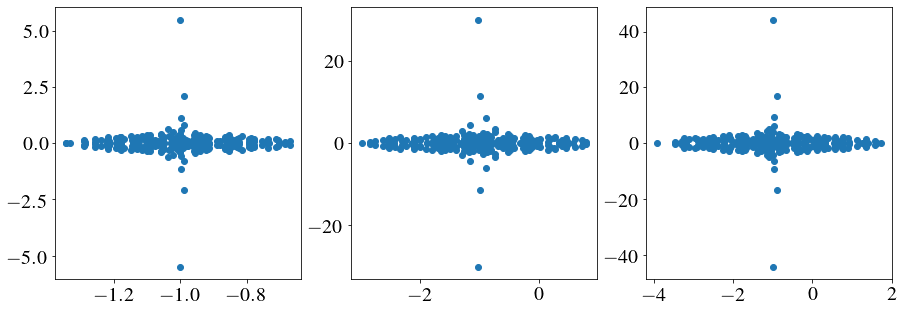

In [540]:
# Scatter plot of eigenvalues for different values of sigma

# Size of the ecosystem
N = 500
# Probability of connection between a pair of species
C = 0.2
# strength of self regulation
d = 1


# adjacency matrix
adj_mat = adjacency_matrix_niche(C, N)

# Stability: sigma < d/sqrt(NC)

sigma = 0.05
W = community_matrix_random_niche(adj_mat, sigma, d)
eigvs = spl.eigvals(W)
fig,axs = plt.subplots(1,3, figsize=(15,5))
axs[0].scatter(x=np.real(eigvs), y=np.imag(eigvs))
# p = sns.jointplot(x=np.real(eigvs), y=np.imag(eigvs), s=5)
# p.fig.suptitle(r"$\sigma = 0.05$", fontsize=15)
# p.set_axis_labels('$Re(\lambda)$', '$Im(\lambda)$', fontsize=15)
# p.ax_marg_x.set_xlim(-6, 6)
# p.ax_marg_y.set_ylim(-6, 6)

# Cusp of instability: sigma = d/sqrt(NC)

sigma = 0.275
W = community_matrix_random_niche(adj_mat, sigma, d)
eigvs = spl.eigvals(W)
axs[1].scatter(x=np.real(eigvs), y=np.imag(eigvs))
# p = sns.jointplot(x=np.real(eigvs), y=np.imag(eigvs), s=5)
# p.fig.suptitle(r"$\sigma = 0.275$", fontsize=15)
# p.set_axis_labels('$Re(\lambda)$', '$Im(\lambda)$', fontsize=15)
# p.ax_marg_x.set_xlim(-6, 6)
# p.ax_marg_y.set_ylim(-6, 6)

# Instability: sigma > sigma_cutoff

sigma = 0.4
W = community_matrix_random_niche(adj_mat, sigma, d)
eigvs = spl.eigvals(W)
axs[2].scatter(x=np.real(eigvs), y=np.imag(eigvs))
# p = sns.jointplot(x=np.real(eigvs), y=np.imag(eigvs), s=5)
# p.fig.suptitle(r"$\sigma = 0.4$", fontsize=15)
# p.set_axis_labels('$Re(\lambda)$', '$Im(\lambda)$', fontsize=15)
# p.ax_marg_x.set_xlim(-6, 6)
# p.ax_marg_y.set_ylim(-6, 6)

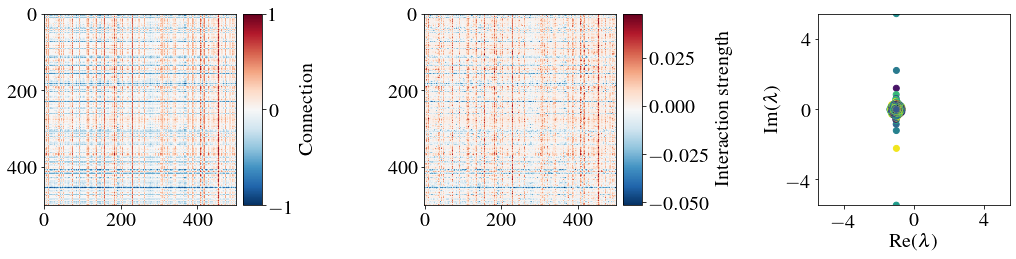

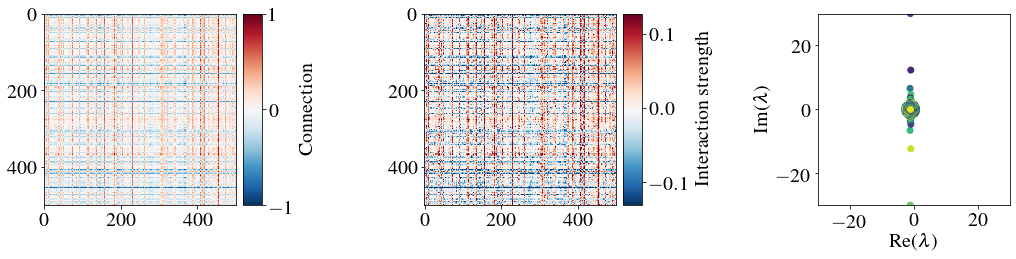

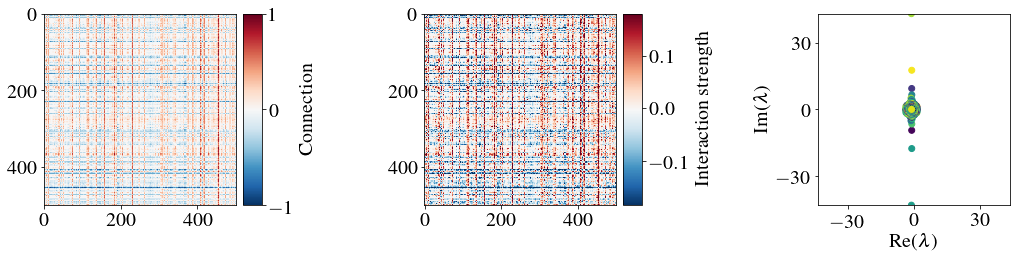

In [170]:
# Size of the ecosystem
N = 500
# Probability of connection between a pair of species
C = 0.2
# strength of self regulation
d = 1

A = adjacency_matrix_niche(C, N)

sigma_cutoff = d/((N*C)**0.5)*(np.pi/(np.pi+2))

sigma = 0.05
fig, axs = plt.subplots(1, 3, figsize=(15,4))
plot_obj_1 = plot_adjacency_matrix(A, axs[0])
W = community_matrix_random_niche(A, sigma=sigma, d=d)
plot_obj_2 = plot_community_matrix(W, axs[1])
eigvs = spl.eigvals(W)
plot_obj_3 = scatter_plot_eigenvalues(eigvs, axs[2])
fig.tight_layout()

sigma = 0.275
fig, axs = plt.subplots(1, 3, figsize=(15,4))
plot_obj_1 = plot_adjacency_matrix(A, axs[0])
W = community_matrix_random_niche(A, sigma=sigma, d=d)
plot_obj_2 = plot_community_matrix(W, axs[1])
eigvs = spl.eigvals(W)
plot_obj_3 = scatter_plot_eigenvalues(eigvs, axs[2])
fig.tight_layout()

sigma = 0.4
fig, axs = plt.subplots(1, 3, figsize=(15,4))
plot_obj_1 = plot_adjacency_matrix(A, axs[0])
W = community_matrix_random_niche(A, sigma=sigma, d=d)
plot_obj_2 = plot_community_matrix(W, axs[1])
eigvs = spl.eigvals(W)
plot_obj_3 = scatter_plot_eigenvalues(eigvs, axs[2])
fig.tight_layout()

## Bipartite mutualism

In [173]:
def adjacency_matrix_bipartite(C, N):
    """
    Function to generate the adjacency matrix for a bipartite graph. We split the total number of N nodes into two 
    groups, each of size N/2. For each pair (i,j) where i is from group 1 and j is from group 2, we make A_ij and A_ji
    non-zero with a probability 2C(N-1)/N. This ensures that the connectance is C.
    
    Input:
    1. C: probability that a pair of off-diagonal elements of the adjacency matrix is non-zero
    2. N: size of the square matrix
    
    Output:
    1. adj_mat: adjacency matrix of zeros and ones    
    """
    # ensure that the value of C is a fraction
    assert C >= 0.0 and C <= 1.0, "The input probability C to the function has to be a fraction"
    assert N%2 == 0, "Please ensure that the number of nodes in the bipartite graph is an even number"
    
    # Initialize adjacency matrix
    adj_mat = np.zeros([N,N], dtype=bool)
    # Probability of an element in the top right quadrant being non-zero
    p = 2*C*(N-1)/N
    # generate a set of binomial random variables and assign those to the top right quadrant
    adj_mat[0:int(N/2), int(N/2):] = np.reshape(np.random.binomial(size=int((N/2)**2), n=1, p=p), [int(N/2), int(N/2)])
    # generate the final adjacency matrix of bipartite mutualistic interactions
    adj_mat = adj_mat + adj_mat.transpose()
    adj_mat[np.diag_indices_from(adj_mat)] = True
    
    return adj_mat

In [174]:
def community_matrix_random_bipartite_mutualism(adj_mat, sigma, d):
    """
    Function that generates a random community matrix for bipartite mutualistic interactions between species. 
    Each non-zero element is derived from a distribution |X| where X ~ normal(0,sigma)    
    
    Input:
    1. adj_mat: Adjacency matrix
    2. sigma: Variance of the gaussian distribution
    3. d: value of diagonal elements
    
    Output:
    1. W: Community matrix of interactions
    """
    # Initialize the community matrix
    shape = np.shape(adj_mat)
    W = np.zeros(shape, dtype=float)
    
    # Sample a list of elements as |X| where X is drawn from a gaussian distribution for the lower triangle
    number_of_non_zero_elements = np.sum(np.abs(adj_mat))
    non_zero_elements = sigma*np.random.randn(number_of_non_zero_elements)
    W[adj_mat!=0] = np.abs(non_zero_elements)
    # make the lower triangle have +ve sign and the upper triangle have negative sign
    W = np.multiply(adj_mat, W)
    
    # Diagonal elements are set to a fixed value
    W[np.diag_indices_from(W)] = -d
    
    return W

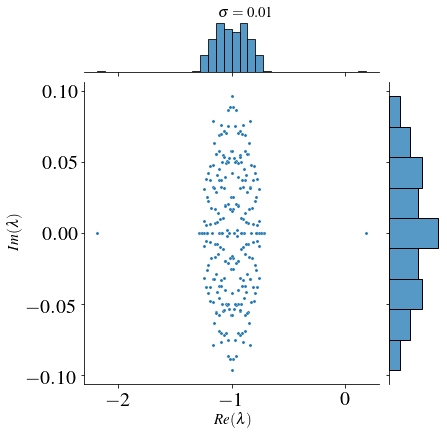

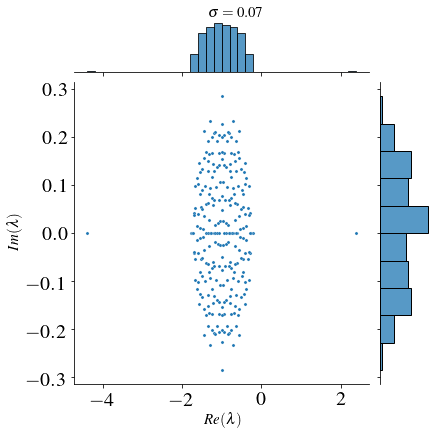

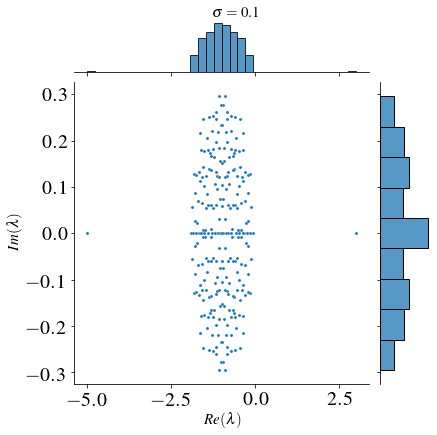

In [568]:
# Scatter plot of eigenvalues for different values of sigma

# Size of the ecosystem
N = 250
# Probability of connection between a pair of species
C = 0.2
# strength of self regulation
d = 1

sigma_cutoff = d/((N*C)**0.5)*(np.pi/(np.pi+2))


# adjacency matrix
adj_mat = adjacency_matrix_bipartite(C, N)

# Stability: sigma < d/sqrt(NC)

sigma = 0.03
W = community_matrix_random_bipartite_mutualism(adj_mat, sigma, d)
eigvs = spl.eigvals(W)
p = sns.jointplot(x=np.real(eigvs), y=np.imag(eigvs), s=10)
p.fig.suptitle(r"$\sigma = 0.01$", fontsize=15)
p.set_axis_labels('$Re(\lambda)$', '$Im(\lambda)$', fontsize=15)
# p.ax_marg_x.set_xlim(-3, 3)
# p.ax_marg_y.set_ylim(-3, 3)

# Cusp of instability: sigma = sigma_cutoff

sigma = sigma_cutoff
W = community_matrix_random_bipartite_mutualism(adj_mat, sigma, d)
eigvs = spl.eigvals(W)
p = sns.jointplot(x=np.real(eigvs), y=np.imag(eigvs), s=10)
p.fig.suptitle(r"$\sigma = 0.07$", fontsize=15)
p.set_axis_labels('$Re(\lambda)$', '$Im(\lambda)$', fontsize=15)
# p.ax_marg_x.set_xlim(-3, 3)
# p.ax_marg_y.set_ylim(-3, 3)

# Instability: sigma > d/sqrt(NC)

sigma = 0.1
W = community_matrix_random_bipartite_mutualism(adj_mat, sigma, d)
eigvs = spl.eigvals(W)
p = sns.jointplot(x=np.real(eigvs), y=np.imag(eigvs), s=10)
p.fig.suptitle(r"$\sigma = 0.1$", fontsize=15)
p.set_axis_labels('$Re(\lambda)$', '$Im(\lambda)$', fontsize=15)
# p.ax_marg_x.set_xlim(-3, 3)
# p.ax_marg_y.set_ylim(-3, 3)

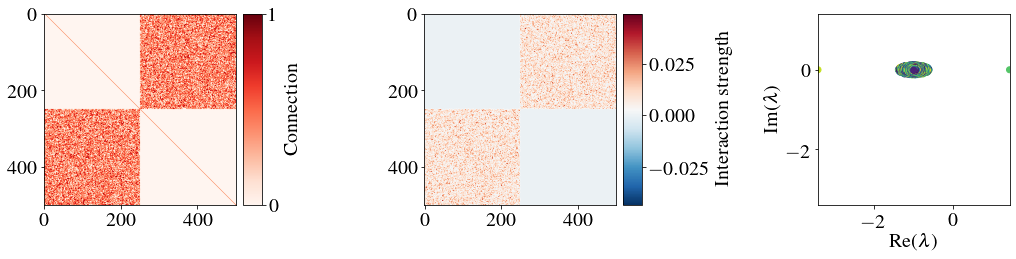

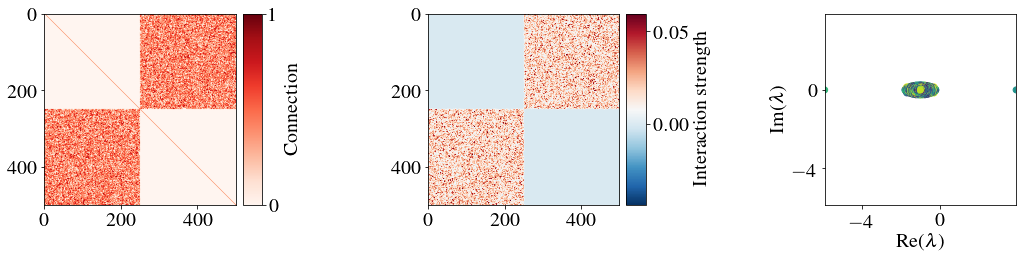

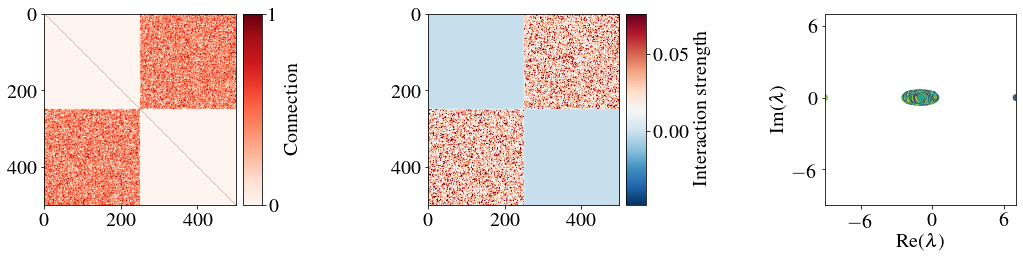

In [176]:
# Size of the ecosystem
N = 500
# Probability of connection between a pair of species
C = 0.2
# strength of self regulation
d = 1

A = adjacency_matrix_bipartite(C, N)

sigma_cutoff = d/((N*C)**0.5)*(np.pi/(np.pi+2))

sigma = 0.03
fig, axs = plt.subplots(1, 3, figsize=(15,4))
plot_obj_1 = plot_adjacency_matrix(A, axs[0])
W = community_matrix_random_bipartite_mutualism(A, sigma=sigma, d=d)
plot_obj_2 = plot_community_matrix(W, axs[1])
eigvs = spl.eigvals(W)
plot_obj_3 = scatter_plot_eigenvalues(eigvs, axs[2])
fig.tight_layout()

sigma = sigma_cutoff
fig, axs = plt.subplots(1, 3, figsize=(15,4))
plot_obj_1 = plot_adjacency_matrix(A, axs[0])
W = community_matrix_random_bipartite_mutualism(A, sigma=sigma, d=d)
plot_obj_2 = plot_community_matrix(W, axs[1])
eigvs = spl.eigvals(W)
plot_obj_3 = scatter_plot_eigenvalues(eigvs, axs[2])
fig.tight_layout()

sigma = 0.1
fig, axs = plt.subplots(1, 3, figsize=(15,4))
plot_obj_1 = plot_adjacency_matrix(A, axs[0])
W = community_matrix_random_bipartite_mutualism(A, sigma=sigma, d=d)
plot_obj_2 = plot_community_matrix(W, axs[1])
eigvs = spl.eigvals(W)
plot_obj_3 = scatter_plot_eigenvalues(eigvs, axs[2])
fig.tight_layout()

### Preferential prey model

In [110]:
def adjacency_matrix_preferential_prey(C, N, tolerance=0.02):
    """
    Function that generates an adjacency matrix for a preferential prey model.
    Preferential prey model as described in: https://www.pnas.org/doi/full/10.1073/pnas.1409077111
    1. Start off with one species in the network
    2. Keep adding species to the network until the total number of species become :math:`$n$`
    3. There are :math:`$i-1$` species present in the network when the :math:`i^{th}`species arrives. Randomly assign one of the :math:`i-1` species as prey to the :math:`i^{th}`species. Call this species :math:'p'
    4. Compute the trophic level of each species :math:`j, j= (1,...,i-1)` given a predation matrix :math:`A, A_{jk} = 1' if :math:`k` is the prey of :math:`j` by solving :math:`s_j=1+\Sigma_{k}A_{jk}s_{k}/\Sigma_{k}A_{jk}
    5. Determine the number of species (:math:`\kappa_i`) to connect to species :math:`i` by generating a beta random variable :math:`x_i \sim Beta(\frac{N^2-1}{2NC}-1,1)` and setting :math:`\kappa_i=(i-1)x_i`
    6. Compute the array :math:`|s_j-s_p|`, sort it in ascending order, and pick out the first :math:`\kappa_i` elements from this array. Assign them as prey to the species :math:`i`
    7. Keep repeating until :math:`i` reaches :math:`N`
    
    Input:
    1. C: probability that the off-diagonal elements of the adjacency matrix is non-zero
    2. N: size of the square matrix
    
    Output:
    1. adj_mat: The function returns the adjacency matrix along with sign. Note that this is a matrix that contains
                +1, -1 and 0. 
    """
    # ensure that the value of C is a fraction
    assert C >= 0.0 and C <= 1.0, "The input probability C to the function has to be a fraction"
    
    # function to calculate trophic level
    def calculate_trophic_level(predation_matrix):
        """
        Function that calculates the trophic level of each species :math:`j, j= (1,...,i-1)` given a predation matrix :math:`A, A_{jk} = 1' if :math:`k` is the prey of :math:`j` by solving :math:`s_j=1+\Sigma_{k}A_{jk}s_{k}/\Sigma_{k}A_{jk}
        """
        shape = np.shape(predation_matrix)
        N = shape[0]
        trophic_level = np.ones(N)

        # compute the in degree for each species
        k_in_array = [np.sum(predation_matrix[j,:]) for j in range(N)]
        # find the species for which in degree is non-zero
        indices = np.nonzero(k_in_array)

        #generate matrix of coefficients to solve the linear equations
        N_nonzero = np.size(indices)
        coefficients = np.zeros([N_nonzero, N_nonzero])
        b = np.zeros(N_nonzero)
        for j in range(N_nonzero):
            prey_accounted = 0
            for k in range(N_nonzero):
                # pdb.set_trace()
                coefficients[j,k] = 1.0*(j==k) - predation_matrix[indices[0][j],indices[0][k]]/k_in_array[indices[0][j]] 
                prey_accounted = prey_accounted + predation_matrix[indices[0][j],indices[0][k]]
            b[j] = 1 + (k_in_array[indices[0][j]] - prey_accounted)/k_in_array[indices[0][j]] 

        # solve the linear equations to get trophic level
        trophic_level_nonzero = spl.solve(coefficients, b)

        # assign the solved values of trophic levels
        for j in range(N_nonzero):
            trophic_level[indices[0][j]] = trophic_level_nonzero[j] 

        return trophic_level
        
    # function to generate predation matrix from the adjacency matrix
    def calculate_predation_matrix(adjacency_matrix):
        """
        Function that computes the predation matrix from the adjacency matrix
        :input adjacency matrix: A matrix that contains 0, +1 and -1. +1 denotes that the column species is the prey of the row species. And vice versa for -1.
        :type adjacency_matrix: int numpy 2darray
        :return predation_matrix: predation matrix :math:`A, A_{jk} = 1' if :math:`k` is the prey of :math:`j`
        :rtype predation_matrix: boolean numpy 2darray 
        """
        shape = np.shape(adjacency_matrix)
        predation_matrix = (adjacency_matrix == 1)
        return predation_matrix
    
    # function to add a new species and generate a new adjacency matrix
    def add_species(adjacency_matrix, N, C):
        """
        Function to add a new species :math:`i` to the adjacency matrix to generate a new adjacency matrix of size :math:`i+1`
        """
        # intialize new adjacency matrix
        shape = np.shape(adjacency_matrix)
        n_i = shape[0]
        adjacency_matrix_new = np.zeros([n_i+1, n_i+1], dtype=int)
        adjacency_matrix_new[0:n_i, 0:n_i] = adjacency_matrix

        # calculate predation matrix
        predation_matrix = calculate_predation_matrix(adjacency_matrix)
        # calculate trophic levels
        trophic_levels = calculate_trophic_level(predation_matrix)

        # calculate the number of prey species to select
        x_i = np.random.beta(a=1.0, b=(N**2-1)/(N*(N-1)*C)-1.0)
        kappa_i = int(np.floor(x_i*n_i))
        # assign prey species
        species_j = int(np.floor(n_i*np.random.rand()))
        # pdb.set_trace()
        distance_metric = np.abs(trophic_levels-trophic_levels[species_j])
        prey_species_selected = np.argsort(distance_metric)
        for i in range(kappa_i):
            adjacency_matrix_new[n_i, prey_species_selected[i]] = 1
            adjacency_matrix_new[prey_species_selected[i], n_i] = -1

        return adjacency_matrix_new
        
    # variable that stores the adjacency matrix at each stage
    
    accept = False
    iter_max = 200
    counter = 0
    while (not accept) and (counter < iter_max):
        adjacency_matrix = np.array([[0]], dtype=int)
        for i in range(2, N+1):
            adjacency_matrix = add_species(adjacency_matrix, N, C)
        counter = counter+1
        print(counter)
        if np.abs(np.sum(np.abs(adjacency_matrix))/(N*(N-1.0)) - C) < tolerance:
            accept = True
    if counter == iter_max:
        print("Warning: the adjacency matrix may not be correct!")
    
    return adjacency_matrix

### Class definition for mixture model

In [117]:
class random_mixture_model:
	"""
	Class definition for a random mixture model including competitive and mutualistic interactions for the ecosystem. This model takes in four parameters as described below and generates the community matrix :math:`W`.

	:param N: Number of species in the ecosystem 
	:param C: Connectance of the graph of interactions. This is the probability that the off-diagonal elements of the adjacency matrix is non-zero.
	:param sigma: Standard deviation of the gaussian distribution from which the interaction strengths are sampled.
	:param d: Strength of the self regulation. This is added as a diagonal element in the community matrix. 
	:type N: int
	:type C: float
	:type sigma: float
	:type d: float

	:ivar N:
	:vartype N: int
	:ivar C: 
	:vartype C: float
	:ivar sigma: 
	:vartype sigma: float
	:ivar d: 
	:vartype d: float
	:ivar adjacency_matrix: Adjacency matrix capturing the network of species-species interactions. This is generated by the function ``adjacency_matrix()``
	:vartype adjacency_matrix: boolean numpy 2darray
	:ivar community_matrix: Community matrix containing pairwise interaction strengths between each pair of species. This is generated by the function ``community_matrix()``
	:vartype community_matrix: float numpy 2darray

	"""

	def __init__(self, N, C, sigma, d):
		self.N = int(N)
		self.C = C
		# ensure that the value of C is a fraction
		assert self.C >= 0.0 and self.C <= 1.0, (
			"The connectance C supplied has to be a fraction")
		self.sigma = sigma
		self.d = d

	def generate_adjacency_matrix(self):
		"""
		Function that generates an adjacency matrix for a random graph, where each link has a probability C of being present. In addition, this also imposes the constraint that if a link between :math:`i` and :math:`j` exists, then a link between :math:`j` and :math:`i` exists as well.

		:return adjacency_matrix: Adjacency matrix of interactions
		:rtype adjacency_matrix: boolean numpy 2darray
		"""
		# generate pairs of non-zero off diagonal elements with probability C
		size_of_upper_triangle = int(self.N*(self.N-1)/2)
		upper_triangular_entries = np.random.random(size_of_upper_triangle)
		
		# construct adjacency matrix by making an upper triangular matrix of the above list
		adjacency_matrix = np.zeros([self.N,self.N], dtype=bool)
		adjacency_matrix[np.triu_indices(self.N, k=1)] = (upper_triangular_entries <= self.C)
		adjacency_matrix = (adjacency_matrix 
			+ adjacency_matrix.transpose())
		adjacency_matrix[np.diag_indices_from(adjacency_matrix)] = True 
		return adjacency_matrix

	def generate_community_matrix(self):
		"""
		Function that generates a random community matrix of a mixture of competition and mutualistic interactions. The pairs of off-diagonal elements :math:`W_{ij}` and :math:`W_{ji}` are each sampled independently from a distribution of :math:`|X|` where :math:`X \sim \mathcal{N}(0,\sigma^2)`. The signs of :math:`W_{ij}` and :math:`W_{ji}` are randomly of same sign or opposite sign.

		:return W: Community matrix associated with this model
		:rtype W: float numpy 2darray
		"""
		adjacency_matrix = self.generate_adjacency_matrix()
		# Initialize the community matrix
		sign_matrix = np.zeros([self.N, self.N], dtype=int)
		W = np.zeros([self.N, self.N], dtype=float)
		
		# Sample a list of elements as |X| where X is drawn from a gaussian distribution
		number_of_non_zero_elements = np.sum(adjacency_matrix)
		non_zero_elements = self.sigma*np.random.randn(
			number_of_non_zero_elements)
		W[adjacency_matrix] = np.abs(non_zero_elements)
		# generate a random string of +1 and -1 for the signs of the upper diagonal elements
		sign_matrix[adjacency_matrix] = 2*(np.random.binomial(
			size=number_of_non_zero_elements, n=1, p= 0.5) - 0.5)
		sign_matrix[np.tril_indices(self.N)] = 0
		sign_matrix = sign_matrix + sign_matrix.transpose()
		# non-zero off-diagonal elements of W matrix are obtained by multiplying the above two matrices
		W[adjacency_matrix] = np.multiply(
			W[adjacency_matrix], 
			sign_matrix[adjacency_matrix])
		
		# Diagonal elements are set to a fixed value
		W[np.diag_indices_from(W)] = -self.d

		return W

### Add predators randomly to a mixture model

In [128]:
class add_predators:
    """
	Class definition for adding predators to the an ecosystem to stabilize it. This model takes in four parameters as described below and generates the community matrix :math:`W`.

	:param base_model: Base model to add predators to. This could be any of the previosuly defined random models 
	:param C: Connectance of the graph of interactions. This is the probability that the elements of the appended adjacency matrix is non-zero.
	:param sigma: Standard deviation of the gaussian distribution from which the interaction strengths are sampled.
	:param d: Strength of the self regulation. This is added as a diagonal element in the community matrix. 
	:type base_model: class object
    :type N: int
	:type C: float
	:type sigma: float
	:type d: float

	:ivar N:
	:vartype N: int
	:ivar C: 
	:vartype C: float
	:ivar sigma: 
	:vartype sigma: float
	:ivar d: 
	:vartype d: float
	:ivar adjacency_matrix: Adjacency matrix capturing the network of species-species interactions. This is generated by the function ``adjacency_matrix()``
	:vartype adjacency_matrix: boolean numpy 2darray
	:ivar community_matrix: Community matrix containing pairwise interaction strengths between each pair of species. This is generated by the function ``community_matrix()``
	:vartype community_matrix: float numpy 2darray

	"""
    
    def __init__(self, base_model, N, C, sigma, d):
		self.base_model = base_model
        self.N = int(N)
		self.C = C
		# ensure that the value of C is a fraction
		assert self.C >= 0.0 and self.C <= 1.0, (
			"The connectance C supplied has to be a fraction")
		self.sigma = sigma
		self.d = d
    
    def generate_adjacency_matrix(self):
        """
        Function that appends interactions corresponding to predators into the base model and generates an appended adjacency matrix
        """
        # generate base adjacency matrix
        adjacency_matrix_base = self.base_model.generate_adjacency_matrix()
        if adjacency_matrix_base.dtype == bool:
            adjacency_matrix_base = np.array(adjacency_matrix_base, dtype=int)
        shape_base = np.shape(adjacency_matrix_base)
        N_base = shape_base[0]
        
        # initialize the adjacency matrix that contains predator interactions
        N_total = N_base+self.N
        adjacency_matrix = np.zeros([N_total, N_total], dtype=int)
        adjacency_matrix[0:N_base, 0:N_base] = adjacency_matrix_base
        
        # append predator interactions
        size_of_top_right_quadrant = N_base*self.N
        elements_top_right_quadrant = -1.0*int(np.random.random(size_of_top_right_quadrant) < self.C)
        adjacency_matrix[0:N_base, N_base:N_total] = np.reshape(elements_top_right_quadrant, (N_base, self.N))
        adjacency_matrix[N_base:N_total, 0:N_base] = adjacency_matrix[0:N_base, N_base:N_total].transpose()
        
        return adjacency_matrix
        
        

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 32)

In [119]:
base_model = random_mixture_model(10, 0.5, 1.0, 4.0)
base_model.generate_adjacency_matrix()

array([[ True,  True,  True, False,  True,  True, False,  True, False,
         True],
       [ True,  True, False,  True,  True,  True,  True,  True, False,
         True],
       [ True, False,  True,  True, False,  True,  True,  True, False,
        False],
       [False,  True,  True,  True, False, False, False,  True, False,
         True],
       [ True,  True, False, False,  True,  True,  True,  True, False,
        False],
       [ True,  True,  True, False,  True,  True,  True, False, False,
         True],
       [False,  True,  True, False,  True,  True,  True, False, False,
         True],
       [ True,  True,  True,  True,  True, False, False,  True, False,
        False],
       [False, False, False, False, False, False, False, False,  True,
         True],
       [ True,  True, False,  True, False,  True,  True, False,  True,
         True]])

In [125]:
a = np.zeros(10, dtype=int)
a = np.array([True, False, True, False,True, False,True, False ])
# a = np.array(a, dtype=int)

In [126]:
print(a.dtype)

bool


## To do:

1. Code to sample 1000 random matrices given an adjacency matrix function, a community matrix generation function, and a specific combination of parameters, and compute the eigenvalues
2. Code that uses this functionality to perform parameter sweeps over a space of parameters and returns a list of eigenvalues for each matrix the probability of stability

In [8]:
# create a function to compute and store eigenvalues

def compute_eigenvalues(iteration_number, adjacency_matrix_function, community_matrix_function, params, hdf5_file_handle):
    """
    Function that computes the eigenvalues of a particular linear model described by the functions 
    adjacency_matrix_function() and community_matrix_function(), for the specific set of parameters in params. 
    This is designed specfically to be used within an embarassingly parallel loop in using joblib and the function
    Parallel()
    
    Inputs:
    1. iteration_number: iteration number within the embarassingly parallel loop. This will also be used as a seed for the 
                         random number generator in each iteration
    2. adjacency_matrix_function(): a function handle for the function that computes and returns the adjacency matrix
    3. community_matrix_function(): a function handle for the function that computes and returns the community matrix
    4. params: parameters that need to be passed to the above two functions. This includes C, N, sigma, and d. 
               params is a dictionary that looks like ['C': ..., 'N': ..., 'sigma': ..., 'd': ...]
    5. hdf5_file_handle: HDF5 file handle to store the eigenvalues
    
    Outputs:
    No outputs. But stores the array of complex eigenvalues computed for each random matrix in a HDF5 file
    """
    
    # seed the random number generator with the iteration number
    np.random.seed(iteration_number)
    # generate adjacency matrix
    A = adjacency_matrix_function(params['C'], params['N'])
    # generate community matrix
    W = community_matrix_function(A, sigma=params['sigma'], d=params['d'])
    # compute eigenvalues
    eigvs = spl.eigvals(W)
    # store in hdf5 file
    dataset_name = 'iteration_' + str(iteration_number)
    hdf5_file_handle.create_dataset(dataset_name, data=eigvs)

In [12]:
# run the parallel loops and store the eigenvalues in the hdf5 file

params = {'C': 0.2, 
          'N': 500, 
          'sigma': 0.1, 
          'd': 1}

with h5py.File('eigenvalues.hdf5','w') as f:
    parallel_function = lambda i: compute_eigenvalues(i, adjacency_matrix_niche, community_matrix_random_niche, params, f) 
    Parallel(n_jobs=2, prefer="threads")(delayed(parallel_function)(i) for i in range(10))

In [17]:
with h5py.File('eigenvalues.hdf5','r') as f:
    print(f['iteration_1'][:])

[-0.99182673+1.08625857e+01j -0.99182673-1.08625857e+01j
 -1.03507151+4.14208995e+00j -1.03507151-4.14208995e+00j
 -0.97352334+2.23254342e+00j -0.97352334-2.23254342e+00j
 -0.99696256+1.54157910e+00j -0.99696256-1.54157910e+00j
 -0.97013928+1.21976547e+00j -0.97013928-1.21976547e+00j
 -1.00620271+1.04102256e+00j -1.00620271-1.04102256e+00j
 -0.97241016+9.24355629e-01j -0.97241016-9.24355629e-01j
 -1.20993612+8.34389178e-01j -1.20993612-8.34389178e-01j
 -0.90161243+8.29879516e-01j -0.90161243-8.29879516e-01j
 -1.12972559+7.54332789e-01j -1.12972559-7.54332789e-01j
 -0.76291422+7.12723270e-01j -0.76291422-7.12723270e-01j
 -0.38063136+3.42254901e-01j -0.38063136-3.42254901e-01j
 -0.30759557+3.44825600e-02j -0.30759557-3.44825600e-02j
 -0.95935537+7.44282643e-01j -0.95935537-7.44282643e-01j
 -1.63955283+2.92851998e-01j -1.63955283-2.92851998e-01j
 -1.7013887 +0.00000000e+00j -1.68807143+5.91316511e-02j
 -1.68807143-5.91316511e-02j -1.64473868+2.18017645e-01j
 -1.64473868-2.18017645e-01j -1